Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib
y[8:13], x[8:13] = [321 321 322 322 322] [125 126 123 124 125]
y[8:13], x[8:13] = [321 321 322 322 322] [125 126 123 124 125]
sp11 = is <Spectrum object named  over spectral range 23.693 : 23.696 GHz and flux range = [-0.1, 2.6] K at 0x7fbc3854dd9>
sp11 new = <Spectrum object named  over spectral range 23.693 : 23.696 GHz and flux range = [-0.1, 2.6] K at 0x7fbc3854dd9>
sp11, sp22, sp33 = <Spectrum object named  over spectral range 23.693 : 23.696 GHz and flux range = [-0.1, 2.6] K at 0x7fbc3854dd9> <Spectrum object named  over spectral range  23.72 : 23.725 GHz and flux range = [-0.3, 1.3] K at 0x7fbc38fb419> <Spectrum object named  over spectral range  23.87 : 23.871 GHz and flux range = [-0.1, 0.7] K at 0x7fbc38e3fd1>
INFO: Creating spectra [pyspeckit.spectrum.classes]
INFO: Concatenating data [pyspeckit.spectrum.classes]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,2100 [p

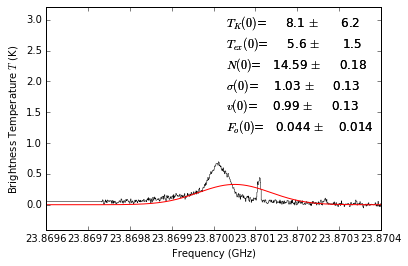

1

In [41]:
# What are the variables we want set as default?
# Taking out the user input leaves much less comparison options? what do we want to compare actually?
# Now bin_width=500, wanted_bin=0 occure as kew words in main() and in binning() function. Is this OK?
# Do we want to have global variable declarations in the header?

import pyspeckit as psk
from spectral_cube import SpectralCube
import astropy.units as u

import GAS
from spectral_cube import SpectralCube
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import astropy.units as u
from astropy.io import fits
from astropy.table import Table

import pyspeckit as psk
from pyspeckit.spectrum.models import ammonia
from pyspeckit.spectrum.models import ammonia_constants, ammonia, ammonia_hf
from pyspeckit.spectrum.models.ammonia_constants import freq_dict
from pyspeckit.spectrum.units import SpectroscopicAxis, SpectroscopicAxes

%pylab
%matplotlib inline

vlsr = fits.getdata('OrionA_NH3_11_base_DR1_mom1.fits')
files =['OrionA_HC7N_22_21_DR1.fits', 'OrionA_HC5N_DR1.fits', 'OrionA_NH3_11_base_DR1.fits', 'OrionA_NH3_33_DR1.fits',
       'OrionA_C2S_DR1.fits',
        'OrionA_HC7N_21_20_DR1.fits', 'OrionA_NH3_22_base_DR1.fits'] #, 'OrionA_NH3_33_DR1_wts.fits'

# lines_margins = {files[0]: [[-1.5, 3.],[6.25, 11.],[18.5,22.5], [-8.5,-4.5], [-21., -16.5]], files[1]: [[-2., 3.], [-17., -13.5], [15.5, 19.]],
#                  files[2]: [[-4.25, 4]], files[3]: [[-1.5, 3.]], files[4]: [[-2, 4.]], files[5]: [[-1.5, 3.]],
#                     files[6]: [[-1.5, 3.]]}
# noise_margins = {files[0]: [12., 17.], files[1]: [5., 12.5], files[2]: [-12, -10], files[3]: [-12, -10], files[4]: [10., 27.5], files[5]: [5., 15.],
#                     files[6]: [5., 15.]}

bin_width = 500
this_bin = 0
# map_name = 'NGC1333_Temperature.fits'
map_name = 'OrionA_NH3_11_base_DR1.fits'
map_binning = 'OrionA_NH3_11_base_DR1_mom0.fits'

def main(this_bin, bin_width):   
    # This is the main routine.
    y, x, med = binning(map_name, bin_width, this_bin)
    
#     plot_spectra(this_bin, bin_width)
#     t, table_names = make_table(files, map_name, this_bin, bin_width, y, x)
#     plot_table(files, map_name, this_bin, bin_width, y, x)
    spec_curve_fit()
#     return t
    return 1

def plot_spectra(this_bin, bin_width):
    loop_count = 0
    fig = plt.figure(figsize=(14,10))
    # for plotting plots in a single figure put plt.figure before all the .plot commands
    # otherwise you will get the plots in a different figures
    
    y, x, med = binning(map_name, bin_width, this_bin)
    # This takes in a 2D map and returns a 2D map where the image values are the bin to which a pixel belongs.
    
    for file_name in files:            
        sp_av, cube = averaging(file_name, y, x)
        thiscube_spectrum_dv, cube, offset_velocity, sp_av = averaging_over_dopplervel(file_name, y, x)
        #Change to velocity axis and such here as well.  Then average all spectra with that bin label.
        ax = fig.add_subplot(len(files),1,loop_count+1)
        plt.plot(offset_velocity,thiscube_spectrum_dv, drawstyle='steps')
        plt.yticks(np.arange(min(thiscube_spectrum_dv), max(thiscube_spectrum_dv), (max(thiscube_spectrum_dv)-min(thiscube_spectrum_dv))/4)) 
        plt.xticks(np.arange(-30, 30, 2.5)) 
    
#         if file_name != files[-1]:
#             plt.setp(ax.get_xticklabels(), visible=False)

        file_name = file_name.strip('L1455_').strip('_all.fits').strip('NGC1333').strip('_DR1_all.fits').strip('OrionA_').strip('_base_DR1.fits')
        plt.legend([file_name], bbox_to_anchor=(1.07, 1.05), prop={'size':8})
        
        loop_count += 1        

#     plt.legend(leg, loc = 5, prop={'size':8})
#     ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
#     fig.legend(curves_names, leg, bbox_to_anchor=(0.5, -0.15))
#     figtext(.1,.0,'averaging over brightness, with doppler v correction, thisbin=2' , fontsize=8)
#     fig.suptitle("averaging over brightness with brightnes bin = %r for bin width = %r" %(this_bin, bin_width), fontsize=12)
    fig.suptitle("OrionA: Averaged spectrum from pixels with $\overline{T}_{antena} = %rK$ \n (bin_width=%r, used brightness bin # = %r, used map = %r)"
                 %(med, bin_width, this_bin, map_name), fontsize=12)
    plt.ylabel(r'$T_{antena} (K)$')
    plt.xlabel(r'$V_{\mathrm{LSR}}\ (km \cdot s^{-1})$')
    plt.savefig("OrionA:BinsAveraging_bin_width=%rthis_bin=%r.ps" %(bin_width, this_bin))
    plt.show()

      
def binning(map_name, bin_width, this_bin):
    """A function creating brightness bins of pixels, and eventualy a map, in the given spectral cube"""
#     cube = SpectralCube.read(map_name)
#     cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
#     Tmax = cube.apply_numpy_function(np.nanmax,axis=0) # array of the maximum values in the spectra of each pixel
#     baddata = nd.morphology.binary_dilation(np.isnan(Tmax),np.ones((25,25)))
#     Tmax[baddata]=0.0
#     Tmax[np.isfinite(Tmax)]
    
    Tmax = fits.getdata(map_binning)
    bin_arr = np.sort(Tmax[np.isfinite(Tmax)])
    bin_arr2 = bin_arr[:: - bin_width] # this creates an array of the bin margins, in which every bin has a width of "bin_width"  
    bins = np.digitize(Tmax,bin_arr2)
#     print 'old bins =', bins
    bins = [x-1 for x in bins] # this and the following line correct the fact that there is otherwise
    bins = np.array(bins) # only one pixel in the bin = 0
#     print type(bins)
#     print 'bins =', bins
    y, x = np.where(bins==this_bin)
    print 'y[8:13], x[8:13] =', y[8:13], x[8:13]
    med = round(np.median(Tmax[y,x]), 2)
#     print 'med in binning():', med
    return y, x, med

def averaging(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    return sp_av, cube

def averaging_over_dopplervel(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    thiscube_spectrum_dv, offset_velocity = GAS.gasBinning.BinByMask(cube, CentroidMap = vlsr, x = x, y = y)
    return thiscube_spectrum_dv, cube, offset_velocity, sp_av


def make_table(files, map_name, this_bin, bin_width, y, x):
    # approach: first loop - make all the columns, with names. First columns will contain all the same data,
    # last ones would be empty.
    # second loop - append all the rows with the data
    
    # Or, create an empty tables. Then create in a loop all the rows. At the end of the loop add the rows
    # to the table. Then just add region, map and bin_width
    # in the title
        
#     table_names = ['map', 'bin width', 'bin#', 'T_med'] + [f.strip('NGC1333').strip('_DR1_all.fits') for f in files]
    table_names = ['map', 'bin width', 'bin#', 'T_med']
    for f in files:
        table_names.append(f.strip('NGC1333').strip('_DR1_all.fits'))
        table_names.append(f.strip('NGC1333').strip('_DR1_all.fits')+'_err')
        
    arr = np.arange(len(table_names)*this_bin).reshape(this_bin, len(table_names))    
    t = Table(arr, names=table_names, meta={'name': 'table'}, dtype=['S30'] + (len(table_names)-1)*['f8'])    
    for bin_num in range(this_bin):
        y, x, med = binning(map_name, bin_width, bin_num)
        row = [map_name, bin_width, bin_num, med]
        for file_name in files:
            thiscube_spectrum_dv, cube, offset_velocity, sp_av = averaging_over_dopplervel(file_name, y, x)
            sp_integral, error_bar = spectral_integral_and_err(offset_velocity, thiscube_spectrum_dv, cube, file_name)
            row.append(sp_integral)
            row.append(error_bar)
        t[bin_num] = row
    
#     t.write('filename.txt', format='latex') # - COOL!!!
#     t.write('NGC1333_bin_width=%r_MaxBin#=%r_no_header.txt' %(bin_width, this_bin), format='ascii.no_header')
#     t.write('OrionA:Table_spec_integrals_corrected_bin_width=%r_MaxBin#=%r_HYPERFINE.txt' %(bin_width, this_bin), format='ascii.fixed_width')
    return t, table_names


def plot_table(files, map_name, this_bin, bin_width, y, x):
    t, table_names = make_table(files, map_name, this_bin, bin_width, y, x)
    fig = plt.figure(figsize=(14,10))
    ax1 = fig.add_subplot(111)
    ax1.set_title("OrionA: Plot of the spectral integrals. Max_bin=%r, bin_width%r.\n Single-pixel-bin corrected, hypefine INCLUDED, real size err_bar"%(this_bin, bin_width))    
    ax1.set_xlabel('$\overline{T_A}$')
    ax1.set_ylabel('$\int T_A dv$ along line of sight')    
    
    print "t['T_med']=", t['T_med']
    for file_name in files:
        column_name = file_name.strip('NGC1333').strip('_DR1_all.fits') 
        ax1.errorbar(t['T_med'], t[column_name], yerr=t[column_name+'_err'], marker='o', linestyle='-', label=str(column_name))
        
        
    leg = ax1.legend(prop={'size':10})
    
#     plt.errorbar(t['T_med'], t[column_name], yerr=y_error)
#     plt.savefig("OrionA:SpeclInteg_CORRECTED_bin_width=%rthis_bin=%r_HYPERFINE.png" %(bin_width, this_bin))
    plt.show()
    
    
def spectral_integral_and_err(offset_velocity, thiscube_spectrum_dv, cube, file_name):
    # first, calculating the integral
    lines_margins = {'NH3_11': [[-1.5, 3.],[6.25, 11.],[18.5,22.5], [-8.5,-4.5], [-21., -16.5]], 'NH3_22': [[-2., 3.], [-17., -13.5], [15.5, 19.]],
                 'NH3_33': [[-4.25, 4]], 'C2S': [[-1.5, 3.]], 'HC5N': [[-2, 4.]], 'HC7N_21_20': [[-1.5, 3.]],
                    'HC7N_22_21': [[-1.5, 3.]]}
    noise_margins = {'NH3_11': [12., 17.], 'NH3_22': [5., 12.5], 'NH3_33': [-12, -10], 'C2S': [-12, -10], 'HC5N': [10., 27.5], 'HC7N_21_20': [5., 15.],
                    'HC7N_22_21': [5., 15.]}
    
    if 'NH3_11' in file_name:
        file_name = 'NH3_11'
    elif 'NH3_22' in file_name:
        file_name = 'NH3_22'
    elif 'NH3_33' in file_name:
        file_name = 'NH3_33'
    elif 'C2S' in file_name:
        file_name = 'C2S'
    elif 'HC5N' in file_name:
        file_name = 'HC5N'
    elif 'HC7N_21_20' in file_name:
        file_name = 'HC7N_21_20'
    elif 'HC7N_22_21' in file_name:
        file_name = 'HC7N_22_21'
        
        
    # in line below calculating the spectral-bin-width, assuming that all spectral-bins have the same width
    spec_bin_w = (cube.spectral_axis[1] - cube.spectral_axis[2])
    sp_integral = 0

    for line_interval in lines_margins[file_name]:
        ind_line = (line_interval[0] < offset_velocity) & (offset_velocity < line_interval[1])
        sp_integral += np.nansum(thiscube_spectrum_dv[ind_line]) * spec_bin_w

# below calculating the error, based on the standard deviation of the signal noise
        ind_offset = (noise_margins[file_name][0] < offset_velocity) & (offset_velocity < noise_margins[file_name][1])
        std_noise = np.nanstd(thiscube_spectrum_dv[ind_offset])
        # Nchan should be the # of channels, that contribute to the integral (= # of data points in spectral line)
        Nchan = len(thiscube_spectrum_dv[ind_line])
        error = std_noise*np.sqrt(Nchan)
     
    return sp_integral.value, error
    
def spec_curve_fit():
    # following loop has not good style. One should build in some break statements or error messages
    # if files repeatedly appear in loop.
    for one_file in files:
        if 'NH3_11' in one_file:
            file_name_NH3_11 = one_file
        if 'NH3_22' in one_file:
            file_name_NH3_22 = one_file
        if 'NH3_33' in one_file:
            file_name_NH3_33 = one_file
        
    y, x, med = binning(map_name, bin_width, this_bin)
    
#     s44 = SpectralCube.read('OrionA_NH3_33_DR1.fits')
#     s44 = s44.with_spectral_unit(u.km/u.s,velocity_convention='radio')
#     sp44 = psk.Spectrum(data=s44[:,140,110].value, xarr=s44.spectral_axis.value,xarrkwargs={'unit':'km/s'},unit='K')
# #     sp44.xarr.convert_to_unit('Hz',refX=s44.header['RESTFRQ'],refX_unit='Hz',velocity_convention='radio')
    
#     sp33, _, _, sp_av = averaging_over_dopplervel(file_name_NH3_33, y, x)
#     print "len(sp33) =", len(sp33)
#     print "len(sp_av) =", len(sp_av)
#     sp44
#     print 'len(sp44) =', len(sp44)
#     print 'sp44 =', sp44[100:200]
    
#     s11, _, _, _ = averaging_over_dopplervel(file_name_NH3_11, y, x)
#     sp11 = psk.Spectrum(data=s11, xarr=s11, xarrkwargs={'unit':'km/s'},unit='K')
#     print 'sp11 = is', sp11
#     sp11.xarr.convert_to_unit('Hz', refX=s11, refX_unit='Hz',velocity_convention='radio') #, refX=sp11.header['RESTFRQ'] taken out here
#     print 'sp11 new =', sp11

   
    xarr11 = SpectroscopicAxis(np.linspace(-25, 25, 700)*u.km/u.s,
                           velocity_convention='radio',
                           refX=freq_dict['oneone']).as_unit(u.GHz)
    xarr22 = SpectroscopicAxis(np.linspace(-30, 30, 700)*u.km/u.s,
                           velocity_convention='radio',
                           refX=freq_dict['twotwo']).as_unit(u.GHz)
    xarr33 = SpectroscopicAxis(np.linspace(-5, 5, 700)*u.km/u.s,
                           velocity_convention='radio',
                           refX=freq_dict['threethree']).as_unit(u.GHz)
    
    
    
    s11, _, _, _ = averaging_over_dopplervel(file_name_NH3_11, y, x)
    sp11 = psk.Spectrum(data=s11, xarr=xarr11, xarrkwargs={'unit':'km/s'},unit='K')
    print 'sp11 = is', sp11
#     sp11.xarr.convert_to_unit('Hz', refX=s11, refX_unit='Hz',velocity_convention='radio') #, refX=sp11.header['RESTFRQ'] taken out here
    print 'sp11 new =', sp11
    
    s22, _, _, _ = averaging_over_dopplervel(file_name_NH3_22, y, x)
    sp22 = psk.Spectrum(data=s22, xarr=xarr22, xarrkwargs={'unit':'km/s'},unit='K')
#     sp22.xarr.convert_to_unit('Hz', refX=s22, refX_unit='Hz',velocity_convention='radio') #, refX=sp11.header['RESTFRQ'] taken out here
    
    s33, _, _, _ = averaging_over_dopplervel(file_name_NH3_33, y, x)
    sp33 = psk.Spectrum(data=s33, xarr=xarr33, xarrkwargs={'unit':'km/s'},unit='K')
#     sp33.xarr.convert_to_unit('Hz', refX=s33, refX_unit='Hz',velocity_convention='radio') #, refX=sp11.header['RESTFRQ'] taken out here
    
    print 'sp11, sp22, sp33 =', sp11, sp22, sp33
    
    # This joins all the spectra together into one object.
    allspec = psk.Spectra([sp11,sp22,sp33])
    allspec.xarr.as_unit('Hz',velocity_convention='radio')
    # This add the cold_ammonia model to the list of things we can use for fitting
    allspec.specfit.Registry.add_fitter('cold_ammonia',ammonia.cold_ammonia_model(),6)
    # This does the fit.  The values of the guess are 
    # Kinetic Temperature (usually about 15 to 25 K)
    # Excitation Temperature (between 2.73 K and the excitation temperature)
    # Log Column Density of ammonia
    # Line width (~1 km/s)
    # Offset velocity (you will usually use 0 instead of 8.5)
    # Ortho fraction (leave at 0)
    allspec.specfit(fittype='cold_ammonia',guesses=[23,5,13.1,1,8.5,0])
    
    # You can make a plot here.
    fig = plt.figure()
    allspec.plotter()
    allspec.specfit.plot_fit(lw=1)
#     plt.xlim((23.692,23.697))
#     plt.xlim((23.72,23.725))
#     plt.xlim((23.8696, 23.8704))
#     plt.savefig("OrionA:pyspeckit_fit_bin_width=%rthis_bin=%r.ps" %(bin_width, this_bin))
#     plt.savefig("OrionA:pyspeckit_fit_NH3_33.ps")
    plt.show()


main(this_bin, bin_width)

In [54]:
x = range(1000)
print x[:1000:10]
x = np.array(x)
print x[:,140,110]

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]


IndexError: too many indices for array

In [51]:
# error message for allspec: "The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()"
# caused by wrong frequency x-axis labeling of the spectrum. the 3 spectra overlap each other and value is ambiguous

In [2]:
import numpy as np
print np.linspace(-30, 30, 100)

[-30.         -29.39393939 -28.78787879 -28.18181818 -27.57575758
 -26.96969697 -26.36363636 -25.75757576 -25.15151515 -24.54545455
 -23.93939394 -23.33333333 -22.72727273 -22.12121212 -21.51515152
 -20.90909091 -20.3030303  -19.6969697  -19.09090909 -18.48484848
 -17.87878788 -17.27272727 -16.66666667 -16.06060606 -15.45454545
 -14.84848485 -14.24242424 -13.63636364 -13.03030303 -12.42424242
 -11.81818182 -11.21212121 -10.60606061 -10.          -9.39393939
  -8.78787879  -8.18181818  -7.57575758  -6.96969697  -6.36363636
  -5.75757576  -5.15151515  -4.54545455  -3.93939394  -3.33333333
  -2.72727273  -2.12121212  -1.51515152  -0.90909091  -0.3030303
   0.3030303    0.90909091   1.51515152   2.12121212   2.72727273
   3.33333333   3.93939394   4.54545455   5.15151515   5.75757576
   6.36363636   6.96969697   7.57575758   8.18181818   8.78787879
   9.39393939  10.          10.60606061  11.21212121  11.81818182
  12.42424242  13.03030303  13.63636364  14.24242424  14.84848485
  15.454545